In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load and Prepare Data

In [2]:
# Load all datasets
fighter_attributes = pd.read_csv('data/fighter_attributes.csv')
fighter_history = pd.read_csv('data/fighter_history.csv')
fighter_stats = pd.read_csv('data/fighter_stats.csv')

print(f"Fighter Attributes: {fighter_attributes.shape[0]:,} fighters")
print(f"Fighter History: {fighter_history.shape[0]:,} fight records")
print(f"Fighter Stats: {fighter_stats.shape[0]:,} stat records")

Fighter Attributes: 3,035 fighters
Fighter History: 17,837 fight records
Fighter Stats: 34,586 stat records


In [3]:
# Preview fighter attributes - focus on country and style
print("Countries in dataset:")
print(fighter_attributes['country'].value_counts().head(20))
print("\nFighting styles:")
print(fighter_attributes['style'].value_counts())

Countries in dataset:
country
usa            1056
brazil          396
canada           76
russia           75
england          70
australia        56
mexico           55
japan            49
poland           38
china            37
france           27
sweden           23
korea            22
ireland          17
argentina        14
germany          13
peru             13
georgia          12
new zealand      12
netherlands      11
Name: count, dtype: int64

Fighting styles:
style
striker                 555
brazilian jiu-jitsu     377
mixed martial artist    211
wrestling               114
freestyle                61
muay thai                37
boxing                   29
kickboxing               28
jiu-jitsu                26
judo                     15
grappling                11
karate                    9
taekwondo                 5
sambo                     5
brawler                   3
kung fu                   3
sanda                     3
thugjitsu                 2
street fighting 

In [4]:
# Define grappling styles
grappling_styles = ['wrestling', 'brazilian jiu-jitsu', 'grappling', 'sambo', 'judo', 'catch wrestling']

# Create grappler flag
fighter_attributes['is_grappler'] = fighter_attributes['style'].str.lower().isin(grappling_styles)

# Create Russian flag
fighter_attributes['is_russian'] = fighter_attributes['country'].str.lower() == 'russia'

# Create combined category
def categorize_fighter(row):
    if row['is_russian'] and row['is_grappler']:
        return 'Russian Grappler'
    elif row['is_russian'] and not row['is_grappler']:
        return 'Russian Non-Grappler'
    elif not row['is_russian'] and row['is_grappler']:
        return 'Non-Russian Grappler'
    else:
        return 'Non-Russian Non-Grappler'

fighter_attributes['fighter_category'] = fighter_attributes.apply(categorize_fighter, axis=1)

print("Fighter Categories:")
print(fighter_attributes['fighter_category'].value_counts())

Fighter Categories:
fighter_category
Non-Russian Non-Grappler    2457
Non-Russian Grappler         503
Russian Non-Grappler          56
Russian Grappler              19
Name: count, dtype: int64


In [5]:
# Calculate win/loss records
fighter_records = fighter_history.groupby('fighter_id').agg({
    'fight_result': [
        lambda x: (x == 'W').sum(),
        lambda x: (x == 'L').sum(),
        'count'
    ],
    'fighter_name': 'first'
})
fighter_records.columns = ['wins', 'losses', 'total_fights', 'fighter_name']
fighter_records['win_rate'] = fighter_records['wins'] / fighter_records['total_fights']
fighter_records = fighter_records.reset_index()

# Calculate fight result types (how they win)
win_types = fighter_history[fighter_history['fight_result'] == 'W'].groupby('fighter_id')['fight_result_type'].value_counts().unstack(fill_value=0)
win_types = win_types.reset_index()

print(f"Fighters with records: {len(fighter_records):,}")

Fighters with records: 3,015


In [6]:
# Aggregate fighter statistics (focus on grappling stats)
fighter_agg_stats = fighter_stats.groupby('fighter_id').agg({
    'TDL': 'sum',  # Takedowns landed
    'TDA': 'sum',  # Takedowns attempted
    'TSL': 'sum',  # Total strikes landed
    'TSA': 'sum',  # Total strikes attempted
    'SSL': 'sum',  # Significant strikes landed
    'SSA': 'sum',  # Significant strikes attempted
    'KD': 'sum',   # Knockdowns
    # Ground stats
    'SGBL': 'sum',  # Strikes to body landed (ground)
    'SGHL': 'sum',  # Strikes to head landed (ground)
    'SM': 'sum',    # Submissions attempted
    'AD': 'sum',    # Advances (position improvements)
    'RV': 'sum',    # Reversals
}).reset_index()

# Calculate derived metrics
fighter_agg_stats['takedown_accuracy'] = fighter_agg_stats['TDL'] / fighter_agg_stats['TDA']
fighter_agg_stats['ground_strikes'] = fighter_agg_stats['SGBL'] + fighter_agg_stats['SGHL']

fighter_agg_stats.head()

,fighter_id,TDL,TDA,TSL,TSA,SSL,SSA,KD,SGBL,SGHL,SM,AD,RV,takedown_accuracy,ground_strikes
0,2220951,1,3,398,757,363,721,3,3,71,0,1,0,0.333333,74
1,2223033,4,14,199,342,108,212,1,3,24,0,0,1,0.285714,27
2,2312150,3,21,416,940,310,791,1,0,6,0,0,0,0.142857,6
3,2335243,9,22,1723,3316,969,2496,6,8,116,11,27,9,0.409091,124
4,2335256,6,15,97,157,27,83,0,10,8,0,5,0,0.400000,18


In [7]:
# Merge all data
df = fighter_attributes.merge(fighter_records, on='fighter_id', how='inner')
df = df.merge(fighter_agg_stats, on='fighter_id', how='left')
df = df.merge(win_types, on='fighter_id', how='left')

# Fill NaN win types with 0
win_type_cols = [col for col in df.columns if col in ['DEC-UNA', 'DEC-SPL', 'DEC-MAJ', 'KO-TKO', 'SUBMISSION', 'DQ']]
df[win_type_cols] = df[win_type_cols].fillna(0)

# Filter for minimum fights
MIN_FIGHTS = 3
df_analysis = df[df['total_fights'] >= MIN_FIGHTS].copy()

# Calculate per-fight metrics
df_analysis['takedowns_per_fight'] = df_analysis['TDL'] / df_analysis['total_fights']
df_analysis['ground_strikes_per_fight'] = df_analysis['ground_strikes'] / df_analysis['total_fights']
df_analysis['submissions_per_fight'] = df_analysis['SM'] / df_analysis['total_fights']

print(f"Fighters for analysis (min {MIN_FIGHTS} fights): {len(df_analysis):,}")
print(f"\nFighter Categories in analysis:")
print(df_analysis['fighter_category'].value_counts())

Fighters for analysis (min 3 fights): 1,904

Fighter Categories in analysis:
fighter_category
Non-Russian Non-Grappler    1416
Non-Russian Grappler         430
Russian Non-Grappler          40
Russian Grappler              18
Name: count, dtype: int64


## 2. Russian Fighters Overview

In [8]:
# Russian fighters breakdown
russian_fighters = df_analysis[df_analysis['is_russian'] == True]

print(f"Total Russian fighters (min {MIN_FIGHTS} fights): {len(russian_fighters)}")
print(f"\nRussian fighters by style:")
print(russian_fighters['style'].value_counts())
print(f"\nRussian grapplers: {russian_fighters['is_grappler'].sum()}")
print(f"Russian non-grapplers: {(~russian_fighters['is_grappler']).sum()}")

Total Russian fighters (min 3 fights): 58

Russian fighters by style:
style
striker                 21
brazilian jiu-jitsu      9
mixed martial artist     7
wrestling                6
sambo                    2
freestyle                1
karate                   1
grappling                1
Name: count, dtype: int64

Russian grapplers: 18
Russian non-grapplers: 40


In [9]:
# Top Russian fighters by wins
top_russians = russian_fighters.nlargest(15, 'wins')[['name', 'style', 'wins', 'losses', 'win_rate', 'total_fights']]
print("Top 15 Russian Fighters by Wins:")
print("="*70)
top_russians

Top 15 Russian Fighters by Wins:


,name,style,wins,losses,win_rate,total_fights
0,Islam Makhachev,wrestling,16,1,0.941176,17
1897,Khabib Nurmagomedov,wrestling,13,0,1.000000,13
333,Magomed Ankalaev,striker,12,1,0.800000,15
395,Alexander Volkov,striker,12,5,0.705882,17
820,Nikita Krylov,brazilian jiu-jitsu,11,9,0.550000,20
922,Petr Yan,striker,11,4,0.733333,15
1588,Rustam Khabilov,NaN,10,3,0.769231,13
403,Muslim Salikhov,striker,9,4,0.692308,13
626,Movsar Evloev,freestyle,9,0,1.000000,9
826,Aleksei Oleinik,brazilian jiu-jitsu,9,8,0.529412,17


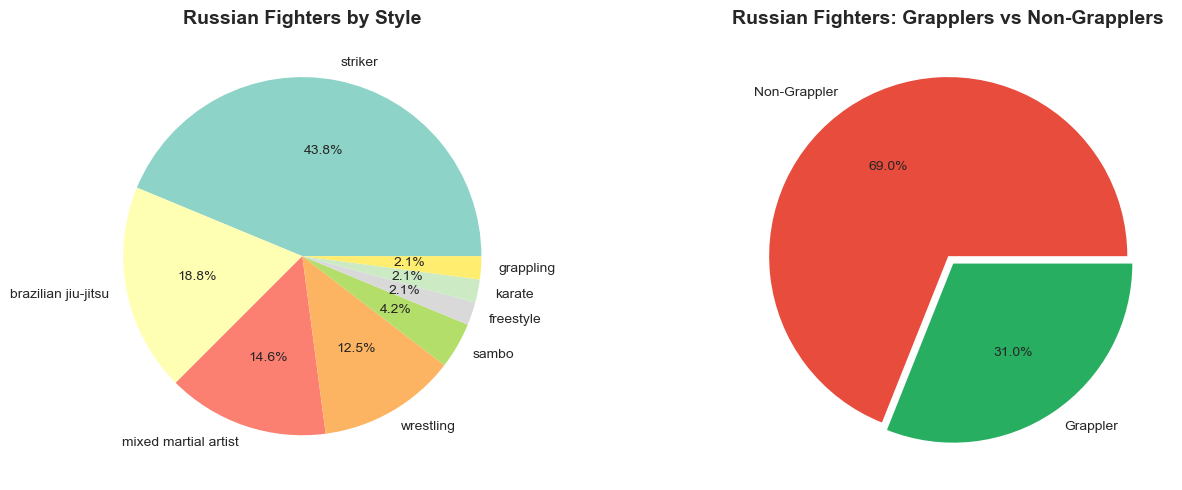

In [10]:
# Visualize Russian fighters by style
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Style distribution
style_counts = russian_fighters['style'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(style_counts)))
axes[0].pie(style_counts.values, labels=style_counts.index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Russian Fighters by Style', fontsize=14, fontweight='bold')

# Grappler vs non-grappler
grappler_counts = russian_fighters['is_grappler'].value_counts()
grappler_labels = ['Non-Grappler', 'Grappler']
axes[1].pie(grappler_counts.values, labels=grappler_labels, autopct='%1.1f%%', 
            colors=['#e74c3c', '#27ae60'], explode=[0, 0.05])
axes[1].set_title('Russian Fighters: Grapplers vs Non-Grapplers', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Win Rate Comparison: Russian Grapplers vs Everyone Else

In [12]:
# Win rate by fighter category
category_stats = df_analysis.groupby('fighter_category').agg({
    'win_rate': ['mean', 'std', 'count'],
    'wins': 'sum',
    'losses': 'sum',
    'total_fights': 'sum'
}).round(4)

category_stats.columns = ['avg_win_rate', 'std_win_rate', 'n_fighters', 'total_wins', 'total_losses', 'total_fights']
category_stats['overall_win_rate'] = category_stats['total_wins'] / category_stats['total_fights']

print("Win Rate Statistics by Fighter Category:")
print("="*80)
category_stats

Win Rate Statistics by Fighter Category:


,avg_win_rate,std_win_rate,n_fighters,total_wins,total_losses,total_fights,overall_win_rate
fighter_category,,,,,,,
Non-Russian Grappler,0.4966,0.1941,430,2557,2058,4710,0.542887
Non-Russian Non-Grappler,0.4559,0.2269,1416,5720,5250,11159,0.512591
Russian Grappler,0.5910,0.2612,18,98,53,152,0.644737
Russian Non-Grappler,0.5987,0.2433,40,185,98,292,0.633562


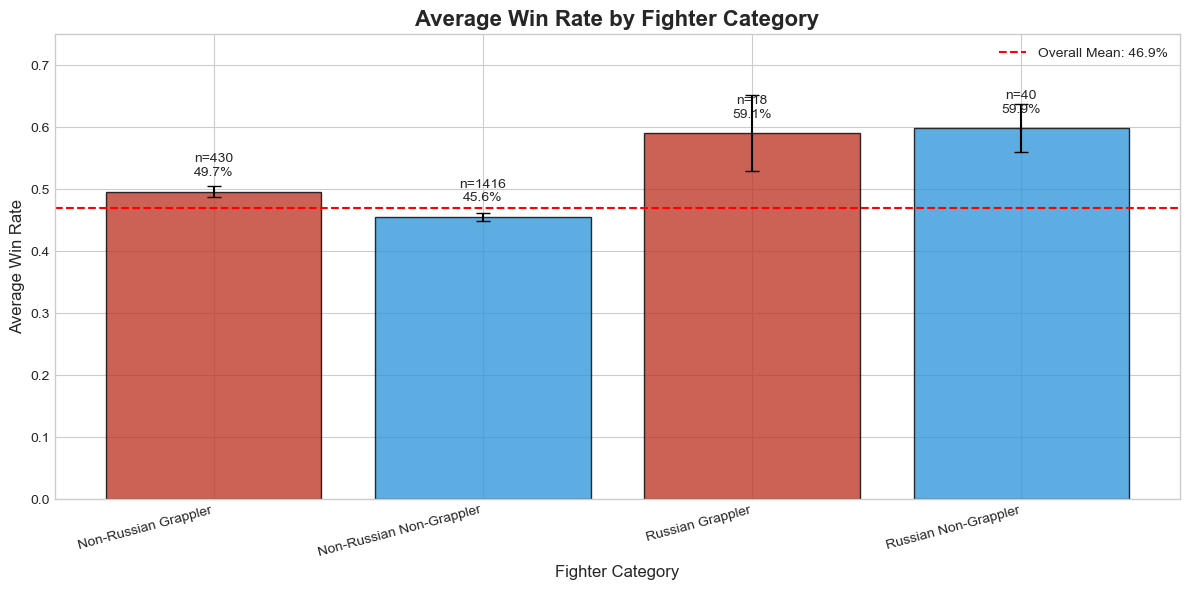

In [13]:
# Bar plot of win rates
fig, ax = plt.subplots(figsize=(12, 6))

categories = category_stats.index.tolist()
win_rates = category_stats['avg_win_rate'].values
std_errors = category_stats['std_win_rate'].values / np.sqrt(category_stats['n_fighters'].values)
counts = category_stats['n_fighters'].values

# Color Russian grapplers differently
colors = ['#c0392b' if 'Russian Grappler' in cat else '#3498db' if 'Russian' in cat else '#95a5a6' for cat in categories]

bars = ax.bar(categories, win_rates, yerr=std_errors, capsize=5, color=colors, edgecolor='black', alpha=0.8)

# Add count labels
for bar, count, rate in zip(bars, counts, win_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'n={count}\n{rate:.1%}', ha='center', va='bottom', fontsize=10)

ax.set_title('Average Win Rate by Fighter Category', fontsize=16, fontweight='bold')
ax.set_xlabel('Fighter Category', fontsize=12)
ax.set_ylabel('Average Win Rate', fontsize=12)
ax.set_ylim(0, 0.75)
ax.axhline(df_analysis['win_rate'].mean(), color='red', linestyle='--', 
           label=f'Overall Mean: {df_analysis["win_rate"].mean():.1%}')
ax.legend()
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

In [14]:
# Statistical tests
russian_grapplers = df_analysis[df_analysis['fighter_category'] == 'Russian Grappler']['win_rate']
non_russian_grapplers = df_analysis[df_analysis['fighter_category'] == 'Non-Russian Grappler']['win_rate']
all_others = df_analysis[df_analysis['fighter_category'] != 'Russian Grappler']['win_rate']

# T-test: Russian grapplers vs all others
t_stat1, p_val1 = ttest_ind(russian_grapplers, all_others)

# T-test: Russian grapplers vs non-Russian grapplers
t_stat2, p_val2 = ttest_ind(russian_grapplers, non_russian_grapplers)

print("STATISTICAL SIGNIFICANCE TESTS")
print("="*60)
print(f"\n1. Russian Grapplers vs ALL Others:")
print(f"   Russian Grapplers Mean: {russian_grapplers.mean():.4f} (n={len(russian_grapplers)})")
print(f"   All Others Mean: {all_others.mean():.4f} (n={len(all_others)})")
print(f"   Difference: {russian_grapplers.mean() - all_others.mean():.4f}")
print(f"   T-statistic: {t_stat1:.4f}")
print(f"   P-value: {p_val1:.4f}")
print(f"   Significant at α=0.05? {'YES' if p_val1 < 0.05 else 'NO'}")

print(f"\n2. Russian Grapplers vs Non-Russian Grapplers:")
print(f"   Russian Grapplers Mean: {russian_grapplers.mean():.4f} (n={len(russian_grapplers)})")
print(f"   Non-Russian Grapplers Mean: {non_russian_grapplers.mean():.4f} (n={len(non_russian_grapplers)})")
print(f"   Difference: {russian_grapplers.mean() - non_russian_grapplers.mean():.4f}")
print(f"   T-statistic: {t_stat2:.4f}")
print(f"   P-value: {p_val2:.4f}")
print(f"   Significant at α=0.05? {'YES' if p_val2 < 0.05 else 'NO'}")

STATISTICAL SIGNIFICANCE TESTS

1. Russian Grapplers vs ALL Others:
   Russian Grapplers Mean: 0.5910 (n=18)
   All Others Mean: 0.4682 (n=1886)
   Difference: 0.1227
   T-statistic: 2.3349
   P-value: 0.0197
   Significant at α=0.05? YES

2. Russian Grapplers vs Non-Russian Grapplers:
   Russian Grapplers Mean: 0.5910 (n=18)
   Non-Russian Grapplers Mean: 0.4966 (n=430)
   Difference: 0.0944
   T-statistic: 1.9904
   P-value: 0.0472
   Significant at α=0.05? YES


## 4. How Do Russian Grapplers Win?

In [16]:
# Analyze win types by category
win_type_cols = ['DEC-UNA', 'DEC-SPL', 'DEC-MAJ', 'KO-TKO', 'SUBMISSION']
available_cols = [col for col in win_type_cols if col in df_analysis.columns]

# Calculate total wins by type for each category
win_type_by_cat = df_analysis.groupby('fighter_category')[available_cols].sum()
win_type_by_cat['Total_Wins'] = win_type_by_cat.sum(axis=1)

# Calculate percentages
win_type_pct = win_type_by_cat[available_cols].div(win_type_by_cat['Total_Wins'], axis=0) * 100

print("Win Type Distribution by Category (%)")
print("="*70)
win_type_pct.round(1)

Win Type Distribution by Category (%)


,DEC-UNA,DEC-MAJ,KO-TKO,SUBMISSION
fighter_category,,,,
Non-Russian Grappler,39.7,0.7,27.6,32.0
Non-Russian Non-Grappler,40.8,0.9,40.0,18.3
Russian Grappler,36.3,0.0,25.3,38.5
Russian Non-Grappler,51.2,0.6,38.8,9.4


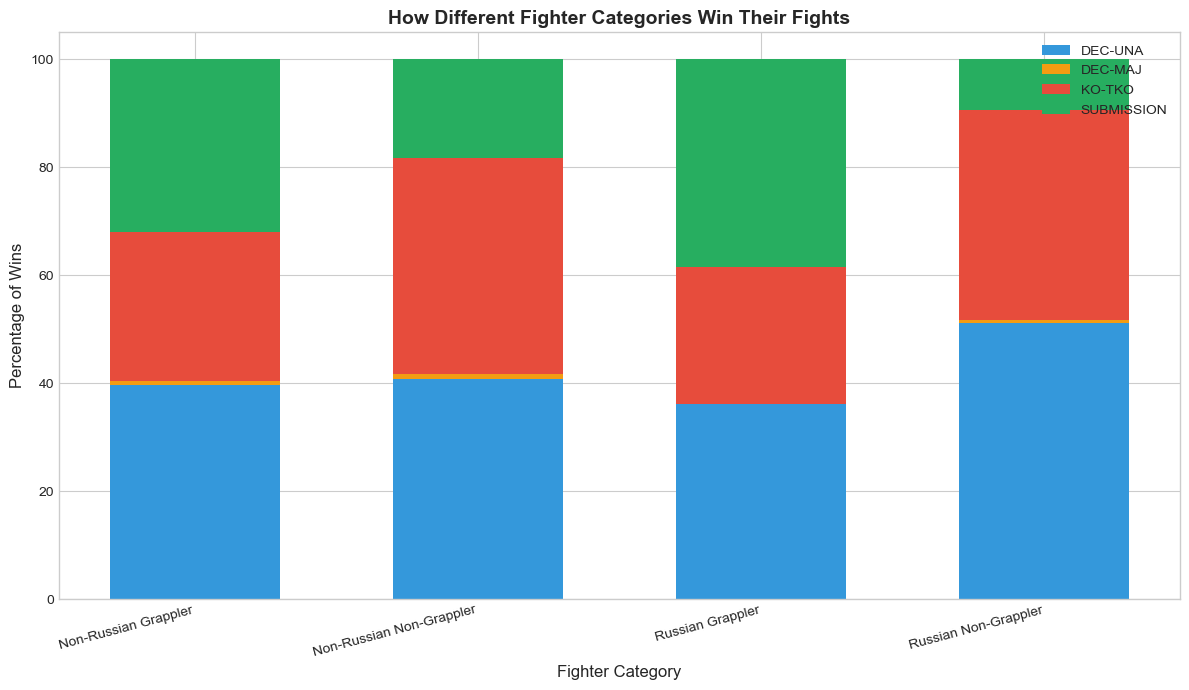

In [17]:
# Stacked bar chart of win types
fig, ax = plt.subplots(figsize=(12, 7))

categories = win_type_pct.index.tolist()
x = np.arange(len(categories))
width = 0.6

colors = {'SUBMISSION': '#27ae60', 'KO-TKO': '#e74c3c', 'DEC-UNA': '#3498db', 
          'DEC-SPL': '#9b59b6', 'DEC-MAJ': '#f39c12'}

bottom = np.zeros(len(categories))
for col in available_cols:
    values = win_type_pct[col].values
    ax.bar(x, values, width, label=col, bottom=bottom, color=colors.get(col, 'gray'))
    bottom += values

ax.set_xlabel('Fighter Category', fontsize=12)
ax.set_ylabel('Percentage of Wins', fontsize=12)
ax.set_title('How Different Fighter Categories Win Their Fights', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=15, ha='right')
ax.legend(loc='upper right')
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

In [18]:
# Focus on submission rate - key metric for grapplers
if 'SUBMISSION' in df_analysis.columns:
    df_analysis['submission_rate'] = df_analysis['SUBMISSION'] / df_analysis['wins']
    df_analysis['submission_rate'] = df_analysis['submission_rate'].fillna(0)
    
    sub_rate_by_cat = df_analysis.groupby('fighter_category')['submission_rate'].agg(['mean', 'std', 'count'])
    print("Submission Rate (% of wins by submission):")
    print("="*60)
    print(sub_rate_by_cat.round(4))

Submission Rate (% of wins by submission):
                            mean     std  count
fighter_category                               
Non-Russian Grappler      0.2893  0.3027    430
Non-Russian Non-Grappler  0.1658  0.2773   1416
Russian Grappler          0.3167  0.3401     18
Russian Non-Grappler      0.1090  0.2540     40


## 5. Grappling Statistics Comparison

In [19]:
# Grappling stats by category
grappling_stats = df_analysis.groupby('fighter_category').agg({
    'takedowns_per_fight': 'mean',
    'takedown_accuracy': 'mean',
    'ground_strikes_per_fight': 'mean',
    'submissions_per_fight': 'mean',
    'TDL': 'sum',
    'TDA': 'sum'
}).round(3)

grappling_stats['overall_td_accuracy'] = grappling_stats['TDL'] / grappling_stats['TDA']

print("Grappling Statistics by Fighter Category:")
print("="*70)
grappling_stats

Grappling Statistics by Fighter Category:


,takedowns_per_fight,takedown_accuracy,ground_strikes_per_fight,submissions_per_fight,TDL,TDA,overall_td_accuracy
fighter_category,,,,,,,
Non-Russian Grappler,1.279,0.365,5.206,0.525,4493.0,12463.0,0.360507
Non-Russian Non-Grappler,0.928,0.388,4.276,0.326,7792.0,20217.0,0.385418
Russian Grappler,1.529,0.357,5.167,0.381,203.0,512.0,0.396484
Russian Non-Grappler,1.141,0.377,4.920,0.120,275.0,684.0,0.402047


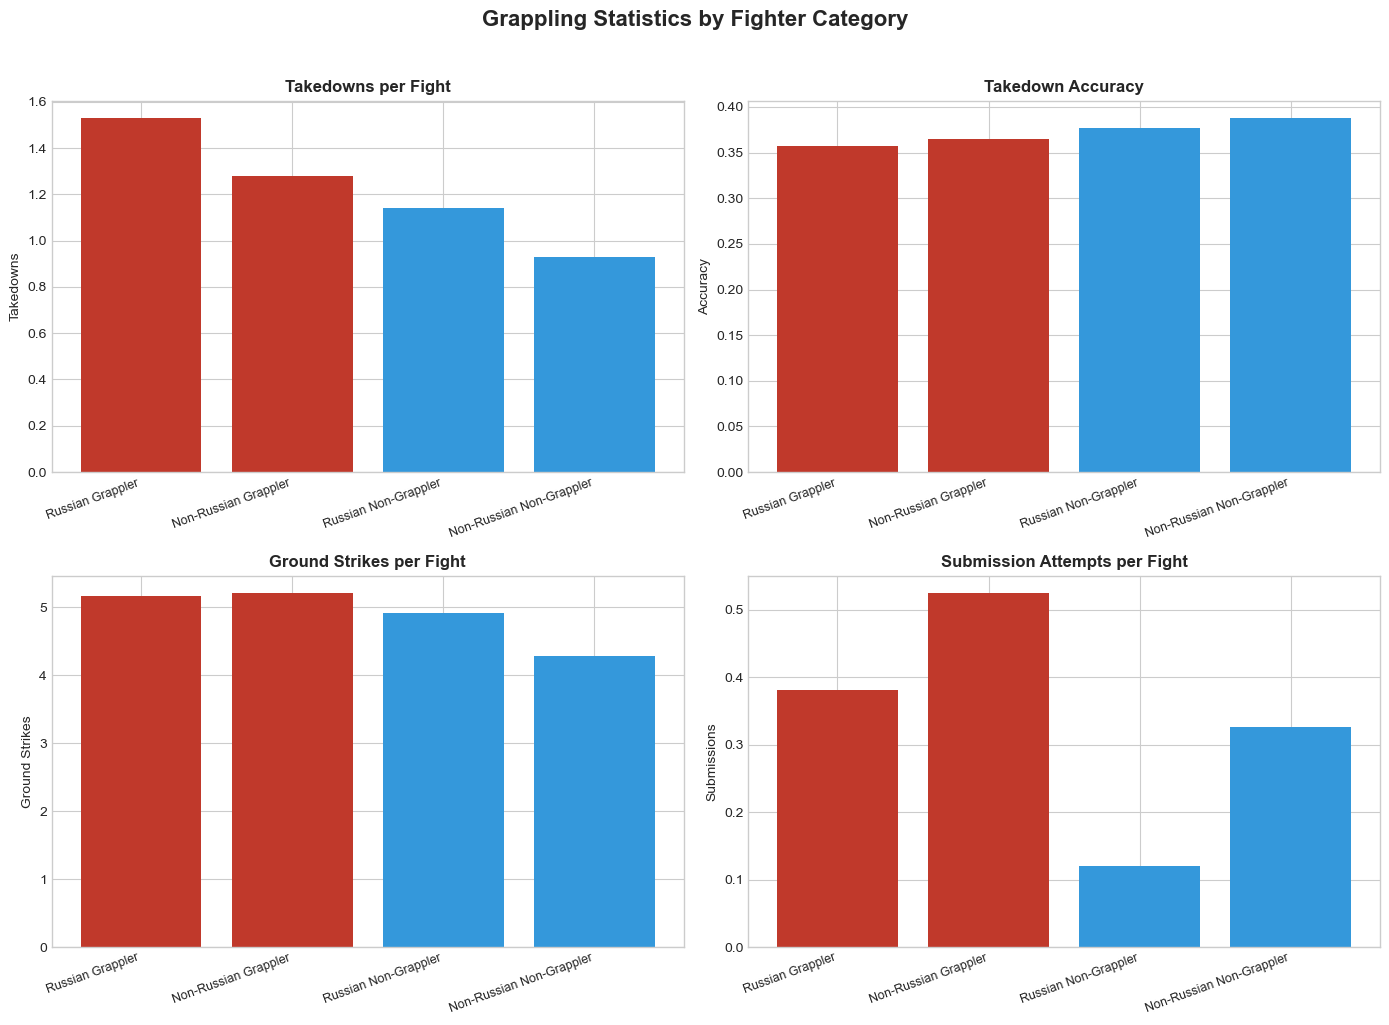

In [20]:
# Visualize grappling stats
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

categories = df_analysis['fighter_category'].unique()
cat_order = ['Russian Grappler', 'Non-Russian Grappler', 'Russian Non-Grappler', 'Non-Russian Non-Grappler']
cat_order = [c for c in cat_order if c in categories]

# Takedowns per fight
td_per_fight = df_analysis.groupby('fighter_category')['takedowns_per_fight'].mean().reindex(cat_order)
colors = ['#c0392b' if 'Russian Grappler' in c else '#3498db' if 'Russian' in c else '#95a5a6' for c in cat_order]
axes[0, 0].bar(range(len(cat_order)), td_per_fight.values, color=colors)
axes[0, 0].set_xticks(range(len(cat_order)))
axes[0, 0].set_xticklabels(cat_order, rotation=20, ha='right', fontsize=9)
axes[0, 0].set_title('Takedowns per Fight', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Takedowns')

# Takedown accuracy
td_acc = df_analysis.groupby('fighter_category')['takedown_accuracy'].mean().reindex(cat_order)
axes[0, 1].bar(range(len(cat_order)), td_acc.values, color=colors)
axes[0, 1].set_xticks(range(len(cat_order)))
axes[0, 1].set_xticklabels(cat_order, rotation=20, ha='right', fontsize=9)
axes[0, 1].set_title('Takedown Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy')

# Ground strikes per fight
gnd_strikes = df_analysis.groupby('fighter_category')['ground_strikes_per_fight'].mean().reindex(cat_order)
axes[1, 0].bar(range(len(cat_order)), gnd_strikes.values, color=colors)
axes[1, 0].set_xticks(range(len(cat_order)))
axes[1, 0].set_xticklabels(cat_order, rotation=20, ha='right', fontsize=9)
axes[1, 0].set_title('Ground Strikes per Fight', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Ground Strikes')

# Submissions attempted per fight
subs = df_analysis.groupby('fighter_category')['submissions_per_fight'].mean().reindex(cat_order)
axes[1, 1].bar(range(len(cat_order)), subs.values, color=colors)
axes[1, 1].set_xticks(range(len(cat_order)))
axes[1, 1].set_xticklabels(cat_order, rotation=20, ha='right', fontsize=9)
axes[1, 1].set_title('Submission Attempts per Fight', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Submissions')

plt.suptitle('Grappling Statistics by Fighter Category', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6. Country Comparison: Grapplers by Nation

In [21]:
# Compare grapplers from different countries
grapplers = df_analysis[df_analysis['is_grappler'] == True].copy()

# Get countries with at least 5 grapplers
country_counts = grapplers['country'].value_counts()
valid_countries = country_counts[country_counts >= 5].index.tolist()

grapplers_by_country = grapplers[grapplers['country'].isin(valid_countries)].groupby('country').agg({
    'win_rate': 'mean',
    'fighter_id': 'count',
    'wins': 'sum',
    'losses': 'sum',
    'takedowns_per_fight': 'mean'
}).rename(columns={'fighter_id': 'n_fighters'})

grapplers_by_country['overall_record'] = grapplers_by_country.apply(
    lambda x: f"{int(x['wins'])}-{int(x['losses'])}", axis=1)
grapplers_by_country = grapplers_by_country.sort_values('win_rate', ascending=False)

print("Grapplers by Country (min 5 fighters):")
print("="*70)
grapplers_by_country.round(3)

Grapplers by Country (min 5 fighters):


,win_rate,n_fighters,wins,losses,takedowns_per_fight,overall_record
country,,,,,,
poland,0.625,5,31,19,2.030,31-19
russia,0.591,18,98,53,1.529,98-53
brazil,0.515,102,606,462,1.220,606-462
usa,0.500,207,1419,1095,1.333,1419-1095
england,0.491,10,42,37,1.940,42-37
canada,0.490,11,63,60,0.996,63-60
mexico,0.457,8,37,35,0.949,37-35
australia,0.419,7,27,32,1.136,27-32
japan,0.410,10,29,44,0.578,29-44


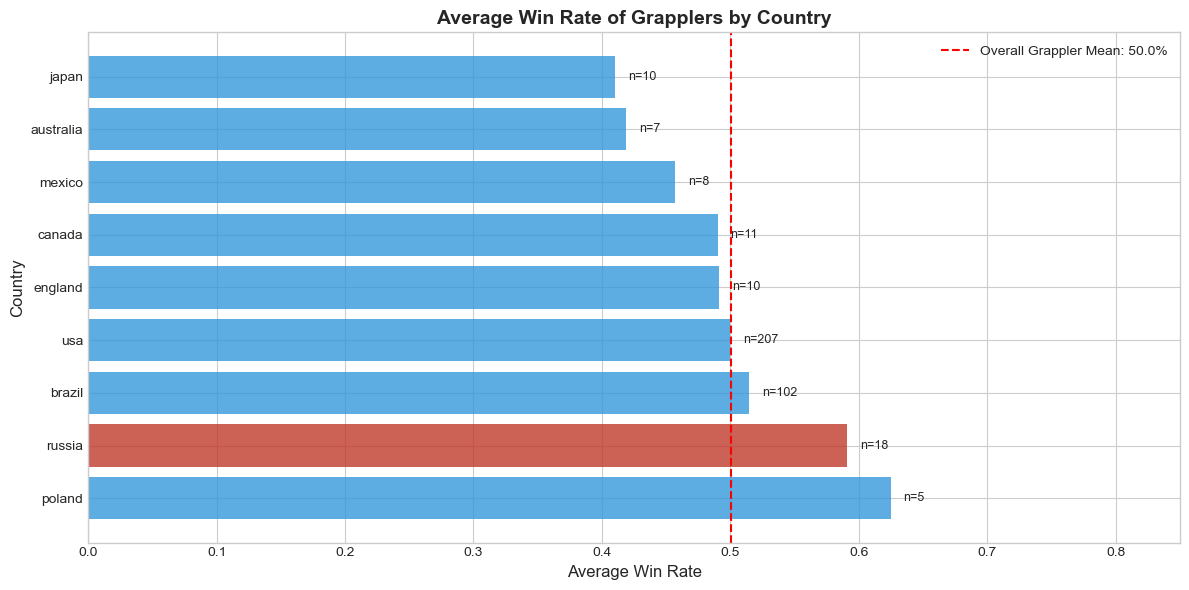

In [22]:
# Visualize grapplers by country
fig, ax = plt.subplots(figsize=(12, 6))

countries = grapplers_by_country.index.tolist()
win_rates = grapplers_by_country['win_rate'].values
counts = grapplers_by_country['n_fighters'].values

# Highlight Russia
colors = ['#c0392b' if c == 'russia' else '#3498db' for c in countries]

bars = ax.barh(countries, win_rates, color=colors, alpha=0.8)

# Add count labels
for bar, count in zip(bars, counts):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'n={count}', ha='left', va='center', fontsize=9)

ax.set_xlabel('Average Win Rate', fontsize=12)
ax.set_ylabel('Country', fontsize=12)
ax.set_title('Average Win Rate of Grapplers by Country', fontsize=14, fontweight='bold')
ax.axvline(grapplers['win_rate'].mean(), color='red', linestyle='--', 
           label=f'Overall Grappler Mean: {grapplers["win_rate"].mean():.1%}')
ax.legend()
ax.set_xlim(0, 0.85)

plt.tight_layout()
plt.show()

## 7. Win Rate Distribution Comparison

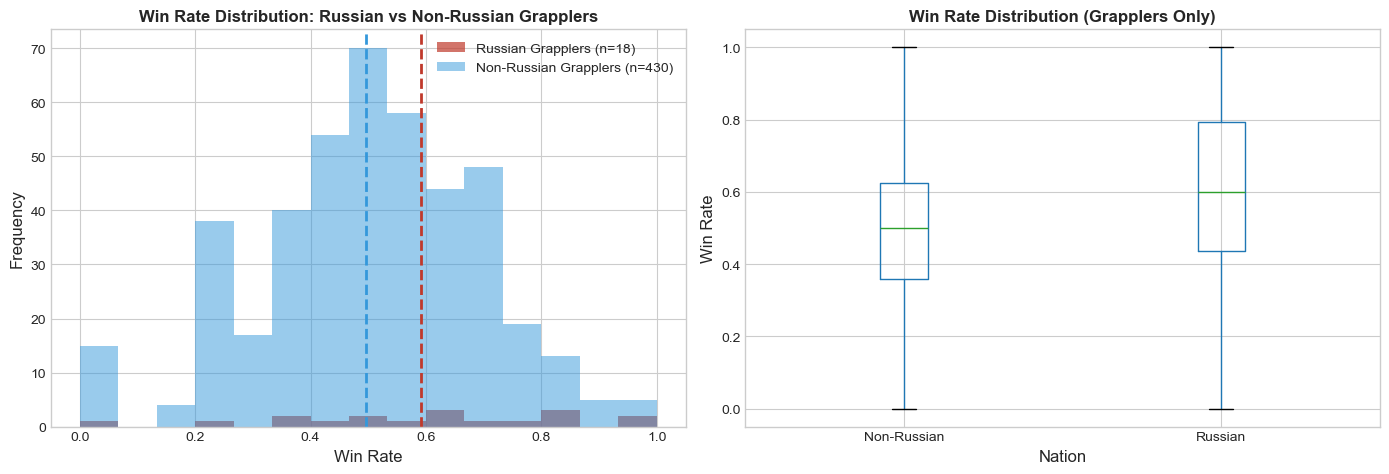

In [23]:
# Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
axes[0].hist(russian_grapplers, bins=15, alpha=0.7, label=f'Russian Grapplers (n={len(russian_grapplers)})', color='#c0392b')
axes[0].hist(non_russian_grapplers, bins=15, alpha=0.5, label=f'Non-Russian Grapplers (n={len(non_russian_grapplers)})', color='#3498db')
axes[0].axvline(russian_grapplers.mean(), color='#c0392b', linestyle='--', linewidth=2)
axes[0].axvline(non_russian_grapplers.mean(), color='#3498db', linestyle='--', linewidth=2)
axes[0].set_xlabel('Win Rate', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Win Rate Distribution: Russian vs Non-Russian Grapplers', fontsize=12, fontweight='bold')
axes[0].legend()

# Box plot
df_grapplers = df_analysis[df_analysis['is_grappler'] == True].copy()
df_grapplers['nation_type'] = df_grapplers['is_russian'].map({True: 'Russian', False: 'Non-Russian'})
df_grapplers.boxplot(column='win_rate', by='nation_type', ax=axes[1])
axes[1].set_xlabel('Nation', fontsize=12)
axes[1].set_ylabel('Win Rate', fontsize=12)
axes[1].set_title('Win Rate Distribution (Grapplers Only)', fontsize=12, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

## 8. Elite Fighter Analysis (High Win Rate)

In [24]:
# Define elite fighters (high win rate with minimum fights)
MIN_FIGHTS_ELITE = 5
ELITE_WIN_RATE = 0.7

df_elite = df_analysis[(df_analysis['total_fights'] >= MIN_FIGHTS_ELITE) & 
                       (df_analysis['win_rate'] >= ELITE_WIN_RATE)].copy()

print(f"Elite Fighters (≥{ELITE_WIN_RATE:.0%} win rate, ≥{MIN_FIGHTS_ELITE} fights): {len(df_elite)}")
print(f"\nElite fighters by category:")
elite_by_cat = df_elite['fighter_category'].value_counts()
print(elite_by_cat)

# Calculate percentage of each category that is elite
total_by_cat = df_analysis[df_analysis['total_fights'] >= MIN_FIGHTS_ELITE]['fighter_category'].value_counts()
elite_pct = (elite_by_cat / total_by_cat * 100).round(1)
print(f"\nPercentage of category that is elite:")
print(elite_pct)

Elite Fighters (≥70% win rate, ≥5 fights): 218

Elite fighters by category:
fighter_category
Non-Russian Non-Grappler    151
Non-Russian Grappler         50
Russian Non-Grappler         11
Russian Grappler              6
Name: count, dtype: int64

Percentage of category that is elite:
fighter_category
Non-Russian Non-Grappler    16.4
Non-Russian Grappler        14.7
Russian Non-Grappler        39.3
Russian Grappler            42.9
Name: count, dtype: float64


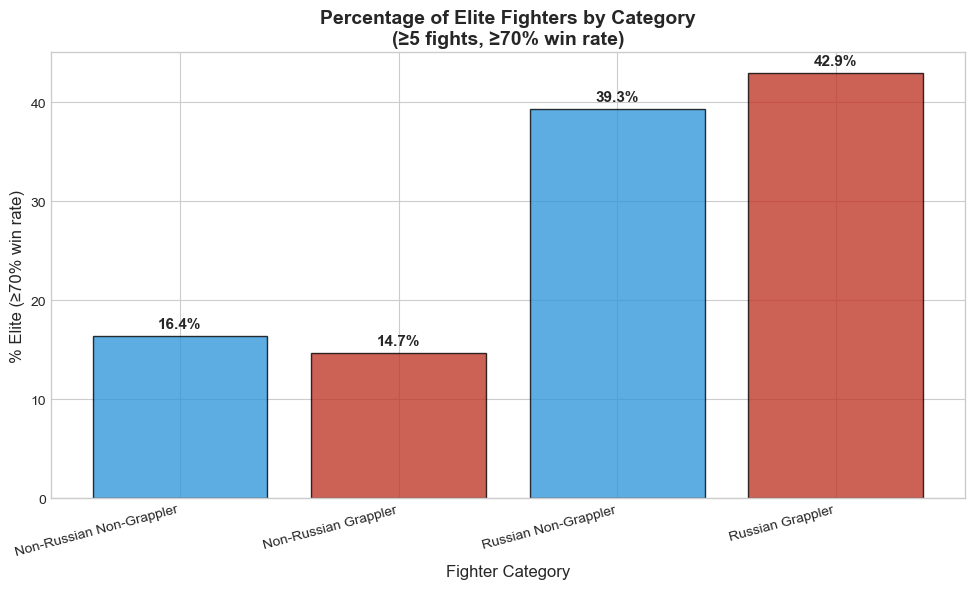

In [25]:
# Visualize elite percentage
fig, ax = plt.subplots(figsize=(10, 6))

categories = elite_pct.index.tolist()
percentages = elite_pct.values

colors = ['#c0392b' if 'Russian Grappler' in c else '#3498db' if 'Russian' in c else '#95a5a6' for c in categories]

bars = ax.bar(categories, percentages, color=colors, edgecolor='black', alpha=0.8)

# Add percentage labels
for bar, pct in zip(bars, percentages):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Fighter Category', fontsize=12)
ax.set_ylabel(f'% Elite (≥{ELITE_WIN_RATE:.0%} win rate)', fontsize=12)
ax.set_title(f'Percentage of Elite Fighters by Category\n(≥{MIN_FIGHTS_ELITE} fights, ≥{ELITE_WIN_RATE:.0%} win rate)', 
             fontsize=14, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

In [26]:
# Top elite Russian grapplers
elite_russian_grapplers = df_elite[df_elite['fighter_category'] == 'Russian Grappler'].sort_values('wins', ascending=False)

if len(elite_russian_grapplers) > 0:
    print("Elite Russian Grapplers:")
    print("="*70)
    display_cols = ['name', 'style', 'wins', 'losses', 'win_rate', 'total_fights']
    print(elite_russian_grapplers[display_cols].head(15).to_string())

Elite Russian Grapplers:
                     name                style  wins  losses  win_rate  total_fights
0         Islam Makhachev            wrestling    16       1  0.941176            17
1897  Khabib Nurmagomedov            wrestling    13       0  1.000000            13
1761     Mairbek Taisumov  brazilian jiu-jitsu     7       2  0.777778             9
115    Rinat Fakhretdinov            wrestling     6       0  0.857143             7
931       Tagir Ulanbekov            wrestling     6       1  0.857143             7
537       Ikram Aliskerov                sambo     4       1  0.800000             5


## 9. Time Trend Analysis: Russian Dominance Over Time

In [27]:
# Analyze fight history over time
fighter_history['event_date'] = pd.to_datetime(fighter_history['event_date'])
fighter_history['year'] = fighter_history['event_date'].dt.year

# Merge with fighter attributes to get category
fight_with_cat = fighter_history.merge(
    fighter_attributes[['fighter_id', 'fighter_category', 'is_russian', 'is_grappler']], 
    on='fighter_id', how='left'
)

# Calculate win rate by year for Russian grapplers vs others
yearly_stats = fight_with_cat.groupby(['year', 'fighter_category']).agg({
    'fight_result': [lambda x: (x == 'W').sum(), 'count']
})
yearly_stats.columns = ['wins', 'total_fights']
yearly_stats['win_rate'] = yearly_stats['wins'] / yearly_stats['total_fights']
yearly_stats = yearly_stats.reset_index()

# Filter for years with sufficient data
yearly_stats = yearly_stats[yearly_stats['total_fights'] >= 10]

yearly_stats.head(10)

,year,fighter_category,wins,total_fights,win_rate
0,1993,Non-Russian Non-Grappler,8,16,0.500000
1,1994,Non-Russian Non-Grappler,31,62,0.500000
2,1995,Non-Russian Non-Grappler,38,80,0.475000
4,1996,Non-Russian Non-Grappler,43,86,0.500000
5,1997,Non-Russian Grappler,12,15,0.800000
6,1997,Non-Russian Non-Grappler,34,74,0.459459
8,1998,Non-Russian Non-Grappler,26,52,0.500000
10,1999,Non-Russian Non-Grappler,42,88,0.477273
12,2000,Non-Russian Non-Grappler,38,81,0.469136
13,2001,Non-Russian Grappler,12,18,0.666667


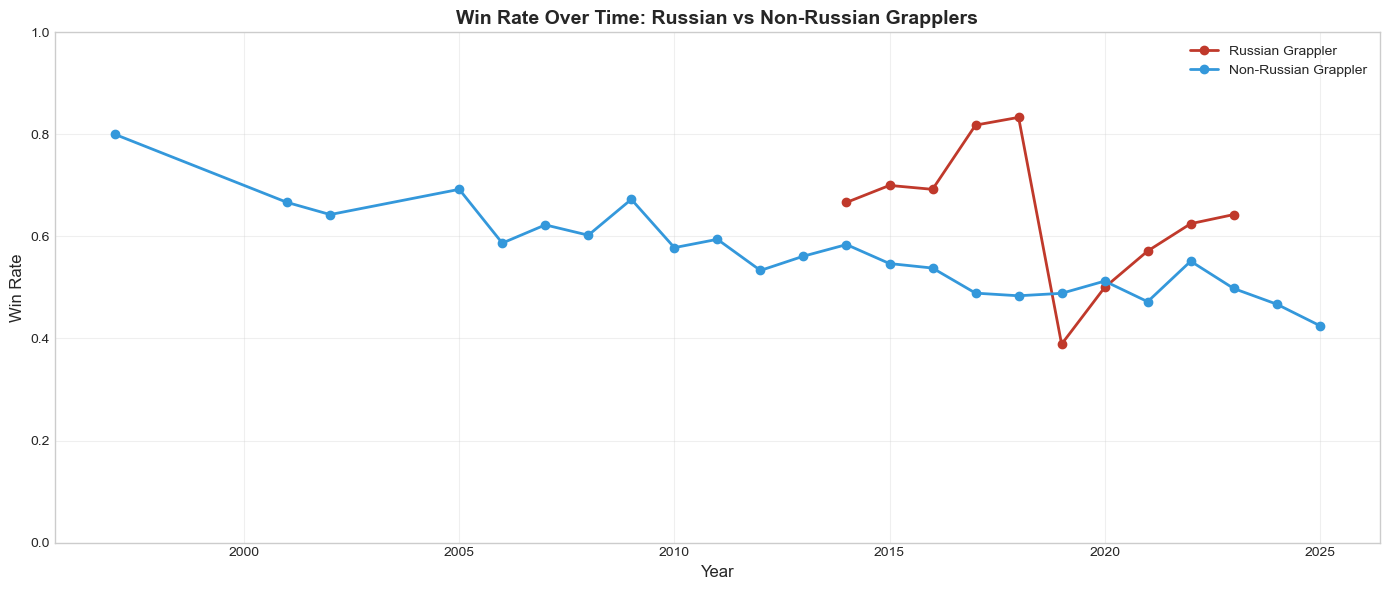

In [28]:
# Plot win rate over time
fig, ax = plt.subplots(figsize=(14, 6))

for cat in ['Russian Grappler', 'Non-Russian Grappler']:
    cat_data = yearly_stats[yearly_stats['fighter_category'] == cat]
    if len(cat_data) > 0:
        color = '#c0392b' if cat == 'Russian Grappler' else '#3498db'
        ax.plot(cat_data['year'], cat_data['win_rate'], 'o-', label=cat, 
                color=color, linewidth=2, markersize=6)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Win Rate', fontsize=12)
ax.set_title('Win Rate Over Time: Russian vs Non-Russian Grapplers', fontsize=14, fontweight='bold')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Summary and Conclusions

In [29]:
# Comprehensive summary
print("="*70)
print("RUSSIAN GRAPPLER DOMINANCE ANALYSIS: SUMMARY")
print("="*70)

print(f"\n📊 SAMPLE SIZE:")
print(f"   Total fighters analyzed: {len(df_analysis):,}")
print(f"   Russian Grapplers: {len(df_analysis[df_analysis['fighter_category'] == 'Russian Grappler'])}")
print(f"   Non-Russian Grapplers: {len(df_analysis[df_analysis['fighter_category'] == 'Non-Russian Grappler'])}")

print(f"\n🏆 WIN RATE COMPARISON:")
print(f"   Russian Grapplers: {russian_grapplers.mean():.1%}")
print(f"   Non-Russian Grapplers: {non_russian_grapplers.mean():.1%}")
print(f"   All Others: {all_others.mean():.1%}")
print(f"   Advantage over non-Russian grapplers: +{(russian_grapplers.mean() - non_russian_grapplers.mean())*100:.1f}%")

print(f"\n📈 STATISTICAL SIGNIFICANCE:")
print(f"   Russian Grapplers vs All Others:")
print(f"      P-value: {p_val1:.4f} {'✅ SIGNIFICANT' if p_val1 < 0.05 else '❌ Not significant'}")
print(f"   Russian Grapplers vs Non-Russian Grapplers:")
print(f"      P-value: {p_val2:.4f} {'✅ SIGNIFICANT' if p_val2 < 0.05 else '❌ Not significant'}")

print(f"\n🥋 GRAPPLING STATS:")
rg_stats = df_analysis[df_analysis['fighter_category'] == 'Russian Grappler']
nrg_stats = df_analysis[df_analysis['fighter_category'] == 'Non-Russian Grappler']
print(f"   Russian Grapplers - Takedowns/fight: {rg_stats['takedowns_per_fight'].mean():.2f}")
print(f"   Non-Russian Grapplers - Takedowns/fight: {nrg_stats['takedowns_per_fight'].mean():.2f}")

print(f"\n🎯 ELITE FIGHTERS (≥70% win rate, ≥5 fights):")
if 'Russian Grappler' in elite_pct.index:
    print(f"   % of Russian Grapplers who are elite: {elite_pct.get('Russian Grappler', 0):.1f}%")
if 'Non-Russian Grappler' in elite_pct.index:
    print(f"   % of Non-Russian Grapplers who are elite: {elite_pct.get('Non-Russian Grappler', 0):.1f}%")

print("\n" + "="*70)
print("CONCLUSION:")
print("="*70)
if p_val2 < 0.05 and russian_grapplers.mean() > non_russian_grapplers.mean():
    print("✅ The data SUPPORTS the hypothesis that Russian grapplers are")
    print("   significantly more dominant than grapplers from other nations.")
elif russian_grapplers.mean() > non_russian_grapplers.mean():
    print("⚠️  Russian grapplers show higher win rates, but the difference")
    print("   is not statistically significant with current sample size.")
else:
    print("❌ The data does not support Russian grappler dominance.")
print("="*70)

RUSSIAN GRAPPLER DOMINANCE ANALYSIS: SUMMARY

📊 SAMPLE SIZE:
   Total fighters analyzed: 1,904
   Russian Grapplers: 18
   Non-Russian Grapplers: 430

🏆 WIN RATE COMPARISON:
   Russian Grapplers: 59.1%
   Non-Russian Grapplers: 49.7%
   All Others: 46.8%
   Advantage over non-Russian grapplers: +9.4%

📈 STATISTICAL SIGNIFICANCE:
   Russian Grapplers vs All Others:
      P-value: 0.0197 ✅ SIGNIFICANT
   Russian Grapplers vs Non-Russian Grapplers:
      P-value: 0.0472 ✅ SIGNIFICANT

🥋 GRAPPLING STATS:
   Russian Grapplers - Takedowns/fight: 1.53
   Non-Russian Grapplers - Takedowns/fight: 1.28

🎯 ELITE FIGHTERS (≥70% win rate, ≥5 fights):
   % of Russian Grapplers who are elite: 42.9%
   % of Non-Russian Grapplers who are elite: 14.7%

CONCLUSION:
✅ The data SUPPORTS the hypothesis that Russian grapplers are
   significantly more dominant than grapplers from other nations.


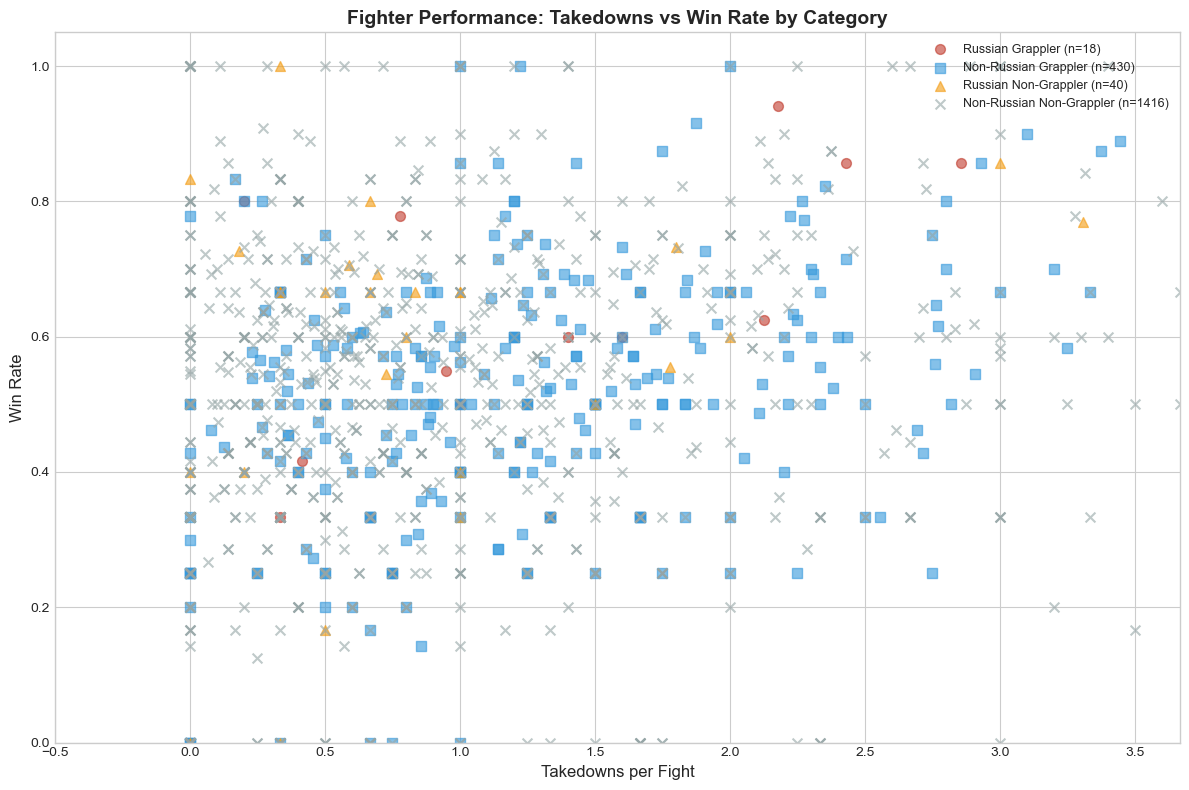

In [30]:
# Final visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter plot: fighters by takedowns and win rate, colored by category
for cat, color, marker in [('Russian Grappler', '#c0392b', 'o'), 
                            ('Non-Russian Grappler', '#3498db', 's'),
                            ('Russian Non-Grappler', '#f39c12', '^'),
                            ('Non-Russian Non-Grappler', '#95a5a6', 'x')]:
    cat_data = df_analysis[df_analysis['fighter_category'] == cat]
    ax.scatter(cat_data['takedowns_per_fight'], cat_data['win_rate'], 
               c=color, marker=marker, label=f"{cat} (n={len(cat_data)})", 
               alpha=0.6, s=50)

ax.set_xlabel('Takedowns per Fight', fontsize=12)
ax.set_ylabel('Win Rate', fontsize=12)
ax.set_title('Fighter Performance: Takedowns vs Win Rate by Category', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.set_xlim(-0.5, df_analysis['takedowns_per_fight'].quantile(0.98))
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()